# Challenge 1 - Plant health classification

The objective of the challenge was categorizing plant as healthy or unhealthy.
<br><br>
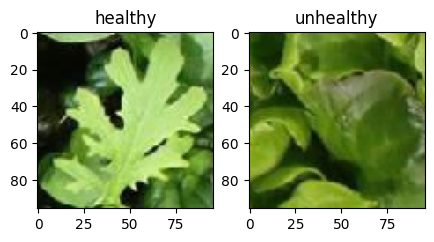

## Import libraries

In [ ]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import logging

In [ ]:
# Import tensorflow
!pip install keras_cv

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras_cv import layers as kcvl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

import cv2
import scipy as sp
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

## Dataset Cleaning

Inspecting the dataset given for the challenge, we noticed some "outliers" in it. So we proceeded to delete all their occurrencies before starting  working on the classification problem.

In [ ]:
dataset = np.load('public_data.npz', allow_pickle=True)
images = dataset['data']
labels = dataset['labels']

# Print shapes of the datasets
print(f"data shape: {images.shape}, Labels shape: {labels.shape}")

data shape: (5200, 96, 96, 3), Labels shape: (5200,)


In [ ]:
num_img = 50
start_index = 0

In [ ]:
fig, axes = plt.subplots(5, num_img//5, figsize=(20, 9))

# Iterate through the selected number of images
for i in range(num_img):
    idx = start_index + i
    ax = axes[i%5, i % num_img//5]
    ax.imshow(np.clip(images[idx].astype('uint8'), 0, 255))
    ax.set_title('{}'.format(labels[idx] + " " + str(idx)))

start_index += num_img

# Adjust layout and display the images
plt.tight_layout()
plt.show()

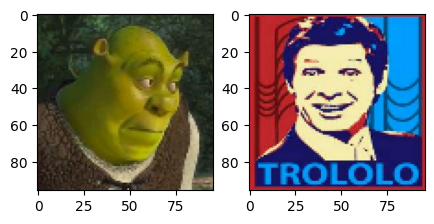

In [ ]:
# Print the two outliers
index_to_show = [58, 338]

fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes = axes.flatten()


for index, ax in zip(index_to_show, axes):
    ax.imshow(np.clip(images[index].astype('uint8'), 0, 255))

plt.show()

In [ ]:
clean_dataset = []
clean_labels = []

In [ ]:
reference_image_shrek = images[58]
reference_image_trololo = images[338]

# Create a new dataset removing the reference images
for idx, image in enumerate(images):
  if not np.array_equal(image, reference_image_shrek) and not np.array_equal(image, reference_image_trololo):
        clean_dataset.append(image)
        clean_labels.append(labels[idx])
  else:
    print(idx)

In [ ]:
# Save the cleaned dataset
np.savez('cleanedUncompressed.npz', data=clean_dataset, labels=clean_labels)

## Dataset loading and splitting

We encoded labels using one-hot encoding and divided the dataset in training and validation with a ratio of 90/10

In [ ]:
dataset = np.load('cleanedUncompressed.npz', allow_pickle=True)
images = dataset['data']
labels = dataset['labels']

# Onehot encoding
onehot = pd.get_dummies(labels)
target = onehot.to_numpy()

unique, count = np.unique(target, return_counts=True, axis=0)
print('Target labels:', unique)
for index, u in enumerate(unique):
    print(f'Class {u} has {count[index]} samples')

print(f"data shape: {images.shape}, Labels shape: {target.shape}")

# Create train and val set
X_train, X_val, y_train, y_val = train_test_split(
    images,
    target,
    test_size = 0.1,
    stratify = target
)


print('Training set shape:\t',X_train.shape, y_train.shape)
print('Validation set shape:\t',X_val.shape, y_val.shape)

## First approach

We started with creating a handcrafted CNN architecture to have a benchmark with future implementations. We are already implementing some Data Augmentation preprocessing and batch normalization to avoid overfitting.
<br><br>
This model clearly overfitted with a training accuracy of more than 99% and the validation accuracy of 88%. When submitted it only obtained a result of 64% accuracy.


In [ ]:
def build_model(input_shape, output_shape):
    preprocessing = tf.keras.Sequential([
        tfkl.Rescaling(scale=1./255),
        tfkl.RandomFlip(),
        tfkl.CenterCrop(input_shape[0], input_shape[1])
    ], name='preprocessing')

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', name='conv1')(preprocessing)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu', name='conv2')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu', name='conv3')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp3')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='valid', activation='relu', name='conv4')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp4')(x)

    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='BasicNetV2')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

## Transfer Learning

We started to use this approach to obtain better results. We tried different architecture from the ones available in Keras Application in order to understand which of the models was better for our use case.


### Xception

In [ ]:
def build_BasicModel(input_shape, output_shape, learning_rate):

    preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(),
        tfkl.CenterCrop(input_shape[0], input_shape[1])
    ], name='preprocessing')

    base_model = tfk.applications.Xception(include_top=False, weights="imagenet", input_tensor=None, input_shape=input_shape, pooling=None,)

    # Freeze every layer in the net
    base_model.trainable = False

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    # Use the xception feature extraction part
    x = base_model(preprocessing, training=False)

    #Build a custom FC part
    global_average = tfkl.GlobalAveragePooling2D()(x)

    dense1 = tfkl.Dense(units=256, activation='relu', kernel_initializer='he_uniform')(global_average)
    bn6 = tfkl.BatchNormalization()(dense1)
    dp4 = tfkl.Dropout(0.5)(bn6)

    output_layer = tfkl.Dense(output_shape, activation='softmax', kernel_initializer='he_uniform',name='Output')(dp4)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

    # Return the model
    return model


### ResNetV2 50

In [ ]:
def build_BasicModel(input_shape, output_shape, learning_rate):

    preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(),
        tfkl.CenterCrop(input_shape[0], input_shape[1])
    ], name='preprocessing')

    base_model = tfk.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

    base_model.trainable = False

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = base_model(preprocessing, training=False)

    #Build a custom FC part
    global_average = tfkl.GlobalAveragePooling2D()(x)

    dense1 = tfkl.Dense(units=512, activation='relu', kernel_initializer='he_uniform')(global_average)
    bn6 = tfkl.BatchNormalization()(dense1)
    dp4 = tfkl.Dropout(0.4)(bn6)

    output_layer = tfkl.Dense(output_shape, activation='softmax', kernel_initializer='he_uniform',name='Output')(dp4)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

    # Return the model
    return model

### MobileNetV2

In [ ]:
def build_BasicModel(input_shape, output_shape, learning_rate):

    preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(),
        tfkl.CenterCrop(input_shape[0], input_shape[1])
    ], name='preprocessing')

    base_model = tfk.applications.MobileNetV2(weights='imagenet',input_shape=input_shape, include_top=False)

    base_model.trainable = False

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = base_model(preprocessing, training=False)

    #Build a custom FC part
    global_average = tfkl.GlobalAveragePooling2D()(x)

    dense1 = tfkl.Dense(units=256, activation='relu', kernel_initializer='he_uniform')(global_average)
    bn6 = tfkl.BatchNormalization()(dense1)
    dp4 = tfkl.Dropout(0.4)(bn6)

    output_layer = tfkl.Dense(output_shape, activation='softmax', kernel_initializer='he_uniform',name='Output')(dp4)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

    # Return the model
    return model

### NASNetMobile

In [ ]:
def build_model(input_shape, output_shape):

    preprocessing = tf.keras.Sequential([
          tfkl.RandomFlip(),
          tfkl.CenterCrop(input_shape[0], input_shape[1]),
      ], name='preprocessing')

    base_model = tfk.applications.NASNetMobile(weights='imagenet', input_shape=input_shape, include_top=False)

    base_model.trainable = False

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    nasnet_preprocess = tfk.applications.nasnet.preprocess_input(input_layer)
    preprocessing = preprocessing(nasnet_preprocess)

    x = base_model(preprocessing, training=False)

    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
    x = tfkl.Dense(units=512, activation='relu', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.Dense(units=256, activation='relu', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.5)(x)


    output_layer = tfkl.Dense(output_shape, activation='softmax', kernel_initializer='he_uniform',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### EfficientNetV2

This was the most promising model among the all the ones that we tried. We tested all the network of this family, apart from EfficientNetV2 L, to understand which of them was performing better. <br> <br>
EfficientNetV2 S was the one with the best results for our tasks and we started to consistently use it trying different configurations and hyperparameters. <br> <br>
This final implementation, with the help of mixup and Test Time Augmentation, was the one that gave us the best results overall, obtaining a 93% accuracy on the test set.

In [ ]:
def build_model(input_shape, output_shape):
    resized_input = (128, 128, 3)

    preprocessing = tf.keras.Sequential([
          # This layer was used before we directly resized the images before applying MixUp
          #tfkl.Resizing(resized_input[0], resized_input[1]),
          kcvl.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.4, magnitude_stddev=0.2, rate=0.6),
      ], name='preprocessing')

    base_model = tfk.applications.EfficientNetV2S(weights='imagenet', input_shape=resized_input, include_top=False)

    base_model.trainable = False

    # image normalization already applied inside EfficientNet
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = base_model(preprocessing, training=False)

    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
    x = tfkl.Dense(units=512, activation='relu', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(1/6)(x)
    x = tfkl.Dense(units=256, activation='relu', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(1/6)(x)


    output_layer = tfkl.Dense(output_shape, activation='softmax', kernel_initializer='he_uniform',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### ConvNext

In the last days of the challenge we felt like we hit a sort of upperbound of performance with EfficientNetV2 S, so we tried another architecture that we didn't already tried before. <br> <br>

We started to use a ConvNext Tiny and we noticed right away that it had potentiality. In parallel at trying to tweak hyperparameters to work well with ConvNext Tiny we started also to try bigger variant such as ConvNext Base.
This was actually the best of the two variants and with two different setups we hit 93% accuracy on the test set. Probably with some more time, and/or a earlier approach to this architecture we would have increased even more our final top accuracy. <br> <br>

We found two different FC that were giving us nice results.

In [ ]:
def build_model(input_shape, output_shape):
    resized_input = (128,128,3)

    preprocessing = tf.keras.Sequential([
          kcvl.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.4, magnitude_stddev=0.2, rate=0.6),
      ], name='preprocessing')

    base_model = tfk.applications.ConvNeXtBase(weights='imagenet', input_shape=resized_input, include_top=False)

    base_model.trainable = False

    input_layer = tfkl.Input(shape=resized_input, name='Input')

    preprocessing = preprocessing(input_layer)

    x = base_model(preprocessing, training=False)

    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
    x = tfkl.Dense(units=512, activation='relu', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(1/6)(x)


    output_layer = tfkl.Dense(output_shape, activation='softmax', kernel_initializer='he_uniform',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_model(input_shape, output_shape):
    resized_input = (128,128,3)

    preprocessing = tf.keras.Sequential([
          # We didn't already resized from the input to (224,224,3) because when applying mixup with that dimension we had an Out Of Memory error for the GPU memory
          tfkl.Resizing(224, 224),
          kcvl.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.4, magnitude_stddev=0.2, rate=0.7),
      ], name='preprocessing')

    base_model = tfk.applications.ConvNeXtBase(weights='imagenet', input_shape=(224,224,3), include_top=False)

    base_model.trainable = False

    input_layer = tfkl.Input(shape=resized_input, name='Input')

    preprocessing = preprocessing(input_layer)

    x = base_model(preprocessing, training=False)

    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
    x = tfkl.Dense(units=512, activation='relu', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(1/6)(x)
    x = tfkl.Dense(units=256, activation='relu', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(1/6)(x)


    output_layer = tfkl.Dense(output_shape, activation='softmax', kernel_initializer='he_uniform',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

## Advanced Data Augmentation

We initially tried to use Keras preprocessing layers in different combinations to apply Data Augmention to the input images. Using these techniques we couldn't get an accuracy higher of 89%.
<br><br>
We then came across the more advanced preprocessing layer provided by KerasCV, in particular we tried CutMix and MixUp in combination with RandAugment. While CutMix didn't gave us a real advantage, MixUp layer helped the model avoid overfitting and improving a lot the performances of the models. Indeed when we implemented MixUp our model went from 89% to 92% test accuracy.

In [ ]:
IMAGE_SIZE = (128,128)

cut_mix = kcvl.CutMix()
mix_up = kcvl.MixUp()

tf.cast(y_train, tf.float32)
X_train = tf.image.resize(X_train, IMAGE_SIZE)
X_val = tf.image.resize(X_val, IMAGE_SIZE)


def pipeline(images, labels):
  labels = tf.cast(labels, "float32")
  output = mix_up({"images": images, "labels": labels})
  #output = cut_mix(output)

  return output['images'], output['labels']


X_train, y_train = pipeline(X_train, y_train)

## Train the models
For the training we used both Early Stopping to avoid overfitting and Learning Rate Reduction to have a better training

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
batch_size = 128
epochs = 200

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, mode='max', restore_best_weights=True)
learning_rate_reduction = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.4, min_lr=1e-5)

epochs = 200

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, learning_rate_reduction]
).history


## Finetuning

We did some experiments on how many layers was better to unfreeze and we found that we had the better results when the models where totally unfreezed (apart from the Batch Normalization layers). <br><br>

For the EfficientNetV2 S the entire unfreezed model fitted in the GPU memory, while for others, such as ConvNext Base, we got a Out of Memory error if totally unfreezed. In these cases we unfreezed as much layers as we could without having the error.

In [ ]:
# Code for unfreezing the whole base model
model.layers[2].trainable = True

for layer in model.layers:
    if isinstance(layer, tfkl.BatchNormalization):
        layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"]
)

model.summary()

In [ ]:
# Code to unfreeze ConvNext Base
def unfreeze_model(model):
    model.layers[2].trainable = True

    start_unfreeze = False

    for layer in model.layers[2].layers:
        if "stage_2_block_15" in layer.name:
            start_unfreeze = True

        if start_unfreeze:
            if not isinstance(layer, tfkl.BatchNormalization):
                layer.trainable = True
        else:
            layer.trainable = False

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"]
    )

unfreeze_model(model)

model.summary()

In [ ]:
# Added checkpoint callback to save the best model during finetuning
checkpoint_filepath = 'checkpoints/'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

epochs = 30
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks = [checkpoint],
).history

In [ ]:
model.load_weights(checkpoint_filepath)
model.save('EfficientNetV2S/FC2_Resize128_NewAugm_Finetuning')

## Data Inference

We used this section to better evaluate the performances of our trained model so that we could classify their performances.

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Test Time Augmentation

In order to gain some others percentage points in accuracy, we implemented in our model.py some Test Time Augmentation techniques. In particular we tried many of the functions available to augment images and we obtained the best results with the following.

Analysis for the best TTA

In [ ]:
def shift(images, shift, axis):
    return np.roll(images, shift, axis=axis)

def rotate(images, angle):
    return sp.ndimage.rotate(images, angle, axes=(1,2),reshape=False, mode='reflect')

def centerCrop(images, central_fraction):
    images = tf.image.central_crop(images, central_fraction)
    images = tf.image.resize(images, IMAGE_SIZE)
    return images

def saturation(images, saturated):
    return tf.image.adjust_saturation(images, saturated)

def brightness(images, bright):
    return tf.image.adjust_brightness(images, bright)

def contrast(images, contrast_factor):
    return tf.image.adjust_contrast(images, contrast_factor)

def grayScale(images):
    return tf.image.rgb_to_grayscale(images)

def flipHor(images):
    return tf.image.flip_left_right(images)

def flipVer(images):
    return tf.image.flip_up_down(images)

def gaussian(images):
    noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1, dtype=tf.float32)
    return tf.add(images, noise)

In [ ]:
pred = model.predict(X_val)

pred_f = model.predict(flip_lr(X_val))

pred_w0 = model.predict(shift(X_val, -3, axis=1))
pred_w1 = model.predict(shift(X_val, 3, axis=1))

pred_h0 = model.predict(shift(X_val, -3, axis=2))
pred_h1 = model.predict(shift(X_val, 3, axis=2))

pred_r0 = model.predict(rotate(X_val, -10))
pred_r1 = model.predict(rotate(X_val, 10))

pred_z0 = model.predict(centerCrop(X_val, 0.9))
pred_z1 = model.predict(centerCrop(X_val, 0.9))

pred_l0 = model.predict(saturation(X_val, 4))
pred_l1 = model.predict(saturation(X_val, 4))

pred_m0 = model.predict(brightness(X_val, 0.3))
pred_m1 = model.predict(brightness(X_val, 0.3))

pred_n0 = model.predict(contrast(X_val, 0.3))
pred_n1 = model.predict(contrast(X_val, 0.3))

pred_f1 = model.predict(flipHor(X_val))
pred_f2 = model.predict(flipVer(X_val))

pred_g = model.predict(gaussian(X_val))

In [ ]:
def agg_acc(predictions, y):
    y_classes = np.argmax(y, axis=1)
    pred_agg = np.mean(predictions, axis=0)
    preds = np.argmax(pred_agg, axis=1)
    acc = np.mean(preds == y_classes)
    return acc

In [ ]:
acc = agg_acc(np.expand_dims(pred, axis=0), y_val)

preds_f = np.stack((pred, pred_f))
acc_f = agg_acc(preds_f, y_val)

preds_w = np.stack((pred, pred_w0, pred_w1))
acc_w = agg_acc(preds_w, y_val)

preds_h = np.stack((pred, pred_h0, pred_h1))
acc_h = agg_acc(preds_h, y_val)

preds_hw = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1))
acc_hw = agg_acc(preds_hw, y_val)

preds_fhw = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2))
acc_fhw = agg_acc(preds_fhw, y_val)

preds_r = np.stack((pred, pred_r0, pred_r1))
acc_r = agg_acc(preds_r, y_val)

preds_fhwr = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1))
acc_fhwr = agg_acc(preds_fhwr, y_val)

preds_z = np.stack((pred, pred_z0, pred_z1))
acc_z = agg_acc(preds_z, y_val)

preds_fhwrz = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1, pred_z0, pred_z1))
acc_fhwrz = agg_acc(preds_fhwrz, y_val)

preds_fhwrz = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1))
acc_fhwrz = agg_acc(preds_fhwrz, y_val)

preds_l = np.stack((pred, pred_l0, pred_l1))
acc_l = agg_acc(preds_l, y_val)

preds_fhwrzl = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1, pred_z0, pred_z1, pred_l0, pred_l1))
acc_fhwrzl = agg_acc(preds_fhwrzl, y_val)

preds_fhwrzl = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1, pred_l0, pred_l1))
acc_fhwrzl = agg_acc(preds_fhwrzl, y_val)

preds_m = np.stack((pred, pred_m0, pred_m1))
acc_m = agg_acc(preds_m, y_val)

preds_fhwrzlm = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1, pred_z0, pred_z1, pred_l0, pred_l1, pred_m0, pred_m1))
acc_fhwrzlm = agg_acc(preds_fhwrzlm, y_val)

preds_fhwrzlm = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1, pred_l0, pred_l1, pred_m0, pred_m1))
acc_fhwrzlm = agg_acc(preds_fhwrzlm, y_val)

preds_n = np.stack((pred, pred_n0, pred_n1))
acc_n = agg_acc(preds_n, y_val)

preds_fhwrzlmn = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1, pred_z0, pred_z1, pred_l0, pred_l1, pred_m0, pred_m1, pred_n0, pred_n1))
acc_fhwrzlmn = agg_acc(preds_fhwrzlmn, y_val)

preds_f1 = np.stack((pred, pred_f1))
acc_f1 = agg_acc(preds_f1, y_val)

preds_f2 = np.stack((pred, pred_f2))
acc_f2 = agg_acc(preds_f2, y_val)

preds_g = np.stack((pred, pred_g))
acc_g = agg_acc(preds_g, y_val)

preds_fhwrzlg = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_r0, pred_r1, pred_l0, pred_l1, pred_g))
acc_fhwrzlg = agg_acc(preds_fhwrzlg, y_val)


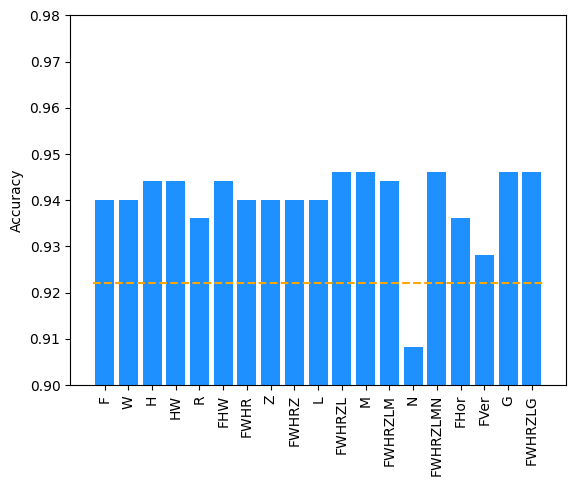

In [ ]:
y = [acc_f, acc_w, acc_h, acc_hw, acc_r, acc_fhw, acc_fhwr, acc_z, acc_fhwrz, acc_l, acc_fhwrzl, acc_m, acc_fhwrzlm, acc_n, acc_fhwrzlmn, acc_f1, acc_f2, acc_g, acc_fhwrzlg]


x = np.arange(len(y))

labels = ['F', 'W', 'H', 'HW', 'R','FHW', 'FWHR', 'Z', 'FWHRZ', 'L', 'FWHRZL', 'M', 'FWHRZLM', 'N', 'FWHRZLMN', 'FHor', 'FVer', 'G', 'FWHRZLG']

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.ylabel('Accuracy')
plt.bar(x, y, color='dodgerblue')
plt.plot([x[0]-0.5, x[-1]+0.5], [acc, acc],
         '--', color='orange')
plt.xticks(x, labels, rotation=90)
plt.ylim(0.90, 0.98)
plt.show()

Final augmentation added in the model.py

In [ ]:
def flipHor(images):
    return tf.image.flip_left_right(images)

def flipVer(images):
    return tf.image.flip_up_down(images)

def shift(images, shift, axis):
    return np.roll(images, shift, axis=axis)

def centerCrop(images, central_fraction):
    images = tf.image.central_crop(images, central_fraction)
    images = tf.image.resize(images, (128, 128))
    return images

def saturation(images, saturated):
    return tf.image.adjust_saturation(images, saturated)


class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):

        X = tf.image.resize(X, (128, 128))

        pred = self.model.predict(X)

        pred_f1 = self.model.predict(flipHor(X))
        pred_f2 = self.model.predict(flipVer(X))

        pred_w0 = self.model.predict(shift(X, -3, axis=1))
        pred_w1 = self.model.predict(shift(X, 3, axis=1))

        pred_h0 = self.model.predict(shift(X, -3, axis=2))
        pred_h1 = self.model.predict(shift(X, 3, axis=2))

        pred_z0 = self.model.predict(centerCrop(X, 0.8))

        pred_l0 = self.model.predict(saturation(X, 4))

        predictions = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f1, pred_f2, pred_z0, pred_l0))
        pred_agg = np.mean(predictions, axis=0)

        out = tf.argmax(pred_agg, axis=-1)

        return out